# NLP and Scoring

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import 	WordNetLemmatizer
from sklearn.model_selection import StratifiedKFold
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\afara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\afara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\afara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\afara\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [25]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"don\'t", "do not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

### Load data

In [26]:
df = pd.read_csv("anime_with_synopsis.csv")
print(len(df))
df.head(10)

16214


,MAL_ID,Name,Score,Genres,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...
5,15,Eyeshield 21,7.95,"Action, Sports, Comedy, Shounen",Sena is like any other shy kid starting high s...
6,16,Hachimitsu to Clover,8.06,"Comedy, Drama, Josei, Romance, Slice of Life","Yuuta Takemoto, a sophomore at an arts college..."
7,17,Hungry Heart: Wild Striker,7.59,"Slice of Life, Comedy, Sports, Shounen",Kyosuke Kano has lived under the shadow of his...
8,18,Initial D Fourth Stage,8.15,"Action, Cars, Sports, Drama, Seinen",Takumi Fujiwara finally joins Ryousuke and Kei...
9,19,Monster,8.76,"Drama, Horror, Mystery, Police, Psychological,...","Dr. Kenzou Tenma, an elite neurosurgeon recent..."


In [27]:
print(df.columns)

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'sypnopsis'], dtype='object')


### Preprocess data/ Clean null entires

In [28]:
#Data Cleaning
# Drop all the rows with Unknown in the 'Score' column
print(df[df['Score'] == 'Unknown'].head(5))
df = df[df['Score'] != 'Unknown']
# Drop all the rows with no synopsis information
print(df[df['sypnopsis'] == 'No synopsis information has been added to this title. Help improve our database by adding a synopsis here .'].head(5))
df = df[df['sypnopsis'] != 'No synopsis information has been added to this title. Help improve our database by adding a synopsis here .']
print(f"Length after Removing Unknow entries: {len(df)}" )

      MAL_ID                                               Name    Score  \
1347    1547                                   Obake no Q-tarou  Unknown   
1439    1656                                    PostPet Momobin  Unknown   
1512    1739                         Shibawanko no Wa no Kokoro  Unknown   
1619    1863                            Silk Road Shounen Yuuto  Unknown   
1808    2073  Hengen Taima Yakou Karura Mau! Sendai Kokeshi ...  Unknown   

                                           Genres  \
1347  Comedy, School, Slice of Life, Supernatural   
1439                                 Comedy, Kids   
1512                                         Kids   
1619               Adventure, Fantasy, Historical   
1808                               Horror, Shoujo   

                                              sypnopsis  
1347  Q-taro, a monster, is living with the Ohara fa...  
1439  omo and Komomo can deliver mail from anyone, t...  
1512  Based on a japanese children`s book by Yoshi

In [29]:
#Turing data into desired format
df['Score'] = df['Score'].astype(float)
df['sypnopsis'] = df['sypnopsis'].astype(str)
df.reset_index(drop=True, inplace=True)
df.head(10)
df['Score_class'] = df['Score'].apply(lambda x: 1 if x >= 7.25 else 0)

### Tokenize data, remove stop words and lemmitize

In [30]:
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
wordnet_lemmatizer = WordNetLemmatizer()

df["tokenized"] = ""
for i in range(len(df)):
    df.loc[i,'sypnopsis'] = df.loc[i,'sypnopsis'].lower()
    df.loc[i,'sypnopsis'] = decontracted(df.loc[i,'sypnopsis'])
    word_tokens = tokenizer.tokenize(df.loc[i,'sypnopsis'])
    lemmatized_tokens = [wordnet_lemmatizer.lemmatize(w) for w in word_tokens]
    filtered_sentence = [w for w in lemmatized_tokens if not w in stop_words and not w.isdigit()]
    df.loc[i,'tokenized'] = " ".join(filtered_sentence)
df.head(10)

,MAL_ID,Name,Score,Genres,sypnopsis,Score_class,tokenized
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","in the year 2071, humanity has colonized sever...",1,year humanity ha colonized several planet moon...
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ...",1,day another bounty life often unlucky crew beb...
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","vash the stampede is the man with a $$60,000,0...",1,vash stampede man bounty head reason merciless...
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...,1,ches individual special power like esp telekin...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",it is the dark century and the people are suff...,0,dark century people suffering rule devil vande...
5,15,Eyeshield 21,7.95,"Action, Sports, Comedy, Shounen",sena is like any other shy kid starting high s...,1,sena like shy kid starting high school trying ...
6,16,Hachimitsu to Clover,8.06,"Comedy, Drama, Josei, Romance, Slice of Life","yuuta takemoto, a sophomore at an arts college...",1,yuuta takemoto sophomore art college share che...
7,17,Hungry Heart: Wild Striker,7.59,"Slice of Life, Comedy, Sports, Shounen",kyosuke kano has lived under the shadow of his...,1,kyosuke kano ha lived shadow successful brothe...
8,18,Initial D Fourth Stage,8.15,"Action, Cars, Sports, Drama, Seinen",takumi fujiwara finally joins ryousuke and kei...,1,takumi fujiwara finally join ryousuke keisuke ...
9,19,Monster,8.76,"Drama, Horror, Mystery, Police, Psychological,...","dr. kenzou tenma, an elite neurosurgeon recent...",1,dr kenzou tenma elite neurosurgeon recently en...


### Apply TF-IDF on the tokenized data

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(df['tokenized'], df['Score'], test_size=0.25, random_state=42)
bin_X_train, bin_X_test, bin_y_train, bin_y_test = train_test_split(df['tokenized'], df['Score_class'], test_size=0.3, random_state=42)
bin_X_val, bin_X_test, bin_y_val, bin_y_test = train_test_split(bin_X_test, bin_y_test, test_size=0.5, random_state=42)

# Preprocess the synopsis text data
vectorizer = TfidfVectorizer(max_features=1024, ngram_range=(1, 2))
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

# Preprocess the synopsis text data for binary classification
bin_vectorizer = TfidfVectorizer(max_features=1024, ngram_range=(1, 2))
bin_vectorizer.fit(bin_X_train)
bin_X_train = bin_vectorizer.transform(bin_X_train)
bin_X_test = bin_vectorizer.transform(bin_X_test)
bin_X_val = bin_vectorizer.transform(bin_X_val)



In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"R2 Score: {r2_score(y_test, y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")


R2 Score: 0.25801794078917384
Mean Squared Error: 0.6360313933399894
Mean Absolute Error: 0.6174331131684736


In [33]:
bin_X_train = bin_X_train.toarray()
bin_X_test = bin_X_test.toarray()
bin_X_val = bin_X_val.toarray()

### Train a Sequential model on the TF-IDF data

In [34]:
from sklearn.metrics import classification_report
from tensorflow.keras import regularizers

# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='tanh', kernel_regularizer=regularizers.l2(0.005), input_shape=(bin_X_train.shape[1],)),
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    # tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_focal_crossentropy', optimizer='sgd', metrics=['accuracy'])
# Train the model
history = model.fit(bin_X_train, bin_y_train, epochs=50, batch_size=32, validation_data=(bin_X_val, bin_y_val), verbose=1)

Epoch 1/50


c:\Users\afara\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7442 - loss: 3.5200 - val_accuracy: 0.7587 - val_loss: 3.3954
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7683 - loss: 3.3551 - val_accuracy: 0.7587 - val_loss: 3.2414
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7684 - loss: 3.2023 - val_accuracy: 0.7587 - val_loss: 3.0948
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7739 - loss: 3.0564 - val_accuracy: 0.7587 - val_loss: 2.9551
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7680 - loss: 2.9201 - val_accuracy: 0.7587 - val_loss: 2.8219
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7623 - loss: 2.7899 - val_accuracy: 0.7587 - val_loss: 2.6950
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7595 - loss: 2.6659 - val_accuracy: 0.7587 - val_loss: 2.5738
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7692 - loss: 2.5428 - val_accuracy: 0.7587 - val_

In [35]:
# Evaluate the model
loss, accuracy = model.evaluate(bin_X_test, bin_y_test)
print(f'Test accuracy: {accuracy}')

y_pred_prob = model.predict(bin_X_test)

y_pred = (y_pred_prob > 0.5).astype("int32")

print(classification_report(bin_y_test, y_pred))

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7654 - loss: 0.4421
Test accuracy: 0.7637362480163574
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1216
           1       0.57      0.35      0.43       422

    accuracy                           0.76      1638
   macro avg       0.68      0.63      0.64      1638
weighted avg       0.74      0.76      0.74      1638



### Plot the model los and validation loss vs the number of epochs

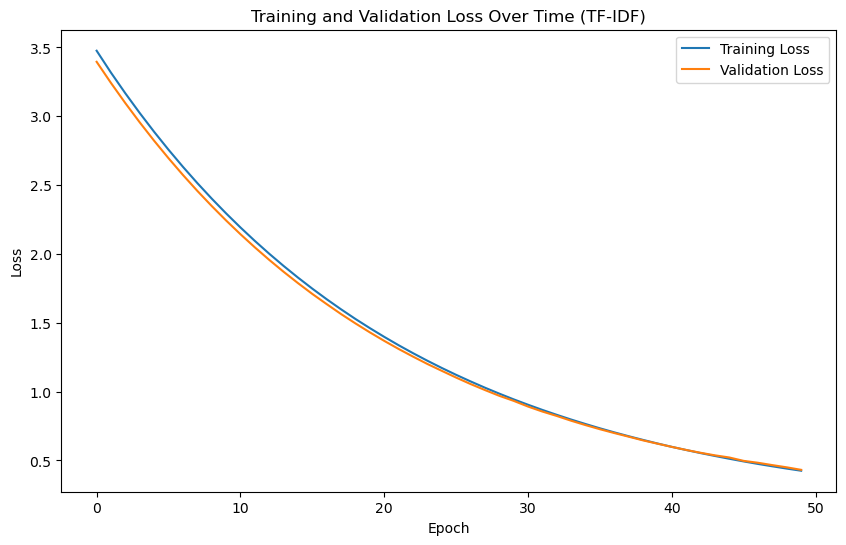

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Time (TF-IDF)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50


c:\Users\afara\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7314 - loss: 3.5240 - val_accuracy: 0.7608 - val_loss: 3.3796
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7691 - loss: 3.3347 - val_accuracy: 0.7608 - val_loss: 3.2047
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7649 - loss: 3.1634 - val_accuracy: 0.7608 - val_loss: 3.0393
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7690 - loss: 2.9994 - val_accuracy: 0.7599 - val_loss: 2.8829
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7700 - loss: 2.8452 - val_accuracy: 0.7608 - val_loss: 2.7353
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7640 - loss: 2.7000 - val_accuracy: 0.7599 - val_loss: 2.5950
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7704 - loss: 2.5602 - val_accuracy: 0.7718 - val_loss: 2.4628
Epoch 8/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7638 - loss: 2.4316 - val_accuracy: 0.7699 - val_

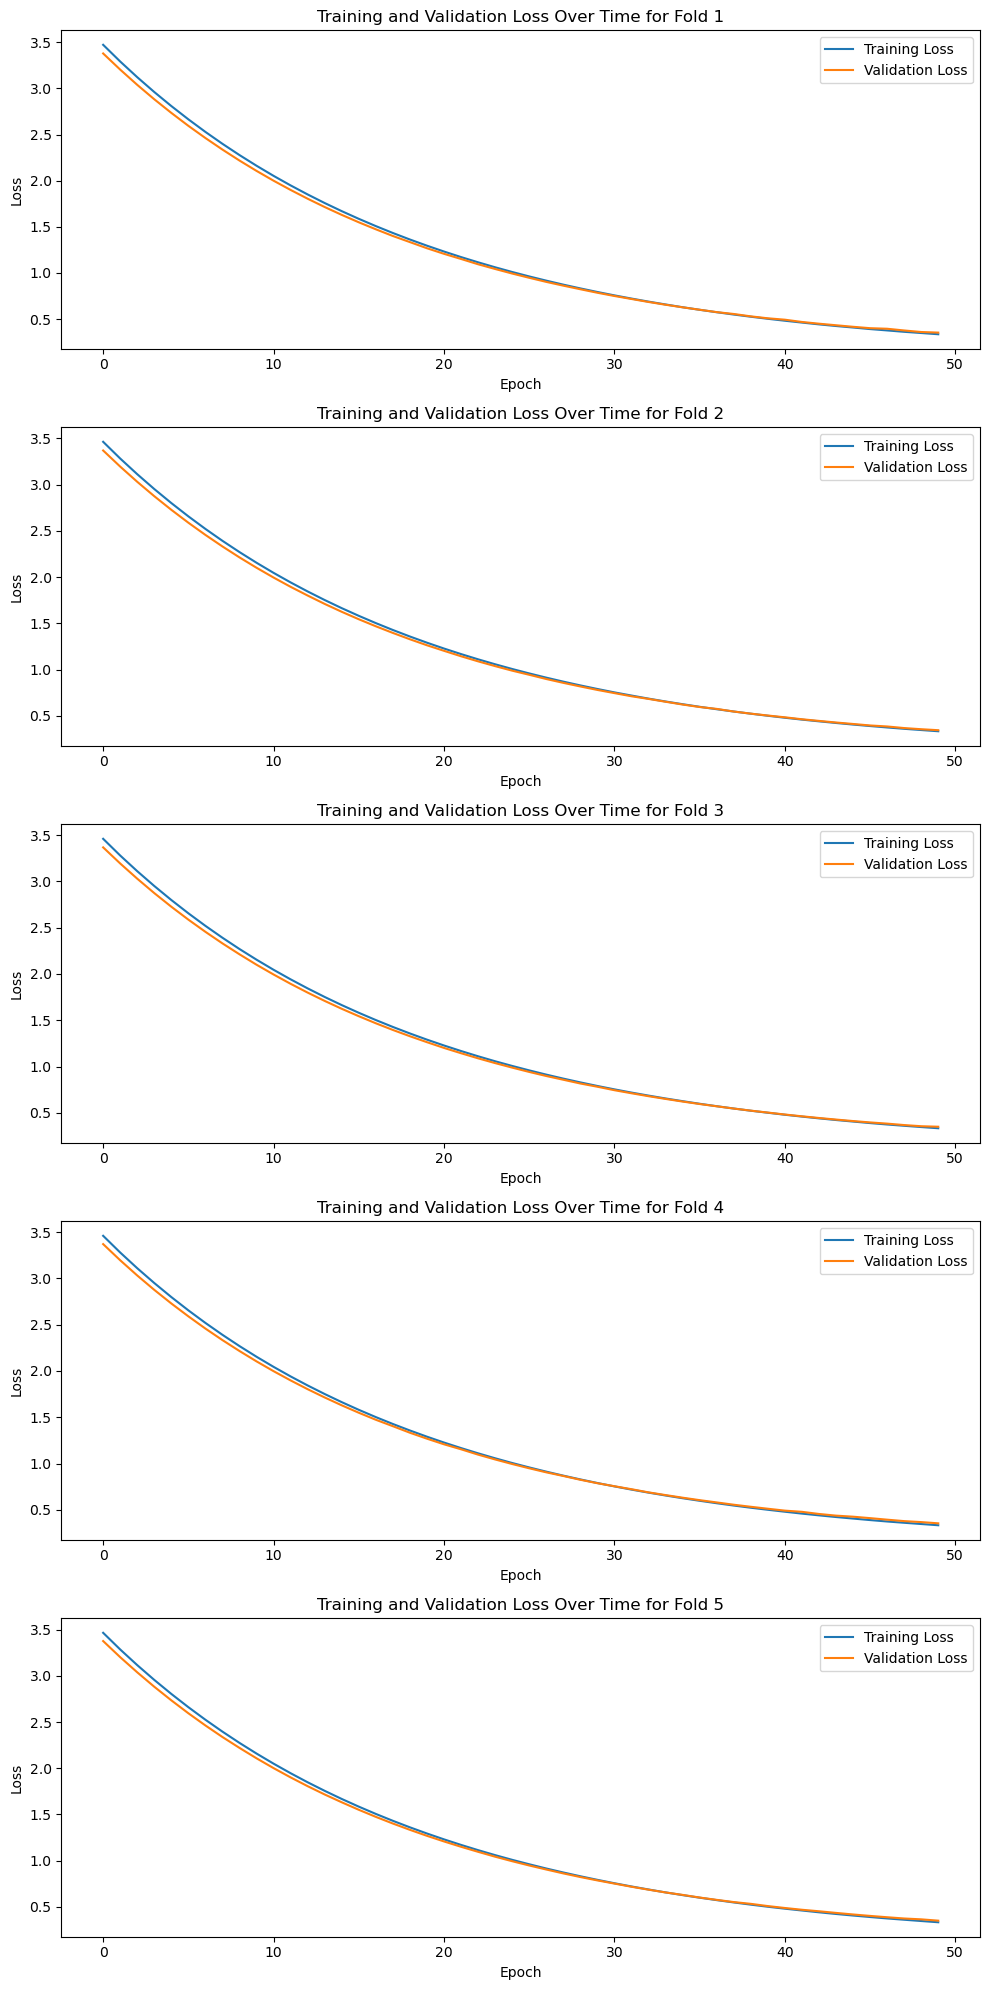

In [37]:
X = df['tokenized']
y = df['Score_class']

kFold = StratifiedKFold(n_splits=5, shuffle=True)

i = 1

accuracies = []
fig, axes = plt.subplots(5,1, figsize=(10, 20))
for train_index, test_index in kFold.split(X, y):
    bin_X_train, bin_X_test = X.iloc[train_index], X.iloc[test_index]
    bin_y_train, bin_y_test = y.iloc[train_index], y.iloc[test_index]
    bin_X_val, bin_X_test, bin_y_val, bin_y_test = train_test_split(bin_X_test, bin_y_test, test_size=0.5, random_state=42)
    bin_vectorizer = TfidfVectorizer(max_features=1024, ngram_range=(1, 2))
    bin_vectorizer.fit(bin_X_train)
    bin_X_train = bin_vectorizer.transform(bin_X_train)
    bin_X_test = bin_vectorizer.transform(bin_X_test)
    bin_X_val = bin_vectorizer.transform(bin_X_val)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(512, activation='tanh', kernel_regularizer=regularizers.l2(0.005), input_shape=(bin_X_train.shape[1],)),
        tf.keras.layers.Dense(256, activation='tanh'),
        tf.keras.layers.Dense(128, activation='tanh'),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(1, activation='sigmoid')])
    model.compile(loss='binary_focal_crossentropy', optimizer='sgd', metrics=['accuracy'])
    print('------------------------------------------------------------------------')
    print(f'Training for fold {i} ...')

    history = model.fit(bin_X_train, bin_y_train, epochs=50, batch_size=32, validation_data=(bin_X_val, bin_y_val), verbose=1)
    loss, accuracy = model.evaluate(bin_X_test, bin_y_test)
    accuracies.append(accuracy)
    ax = axes[i-1]
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_title('Training and Validation Loss Over Time for Fold ' + str(i))
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    i+=1
    
plt.tight_layout()
plt.show()
    

In [38]:
mean_accuracy = np.mean(accuracies)
print(f'Mean accuracy: {mean_accuracy}')
print(accuracies)

Mean accuracy: 0.7785714387893676
[0.7609890103340149, 0.7774725556373596, 0.7902930378913879, 0.7692307829856873, 0.7948718070983887]


<ErrorbarContainer object of 3 artists>

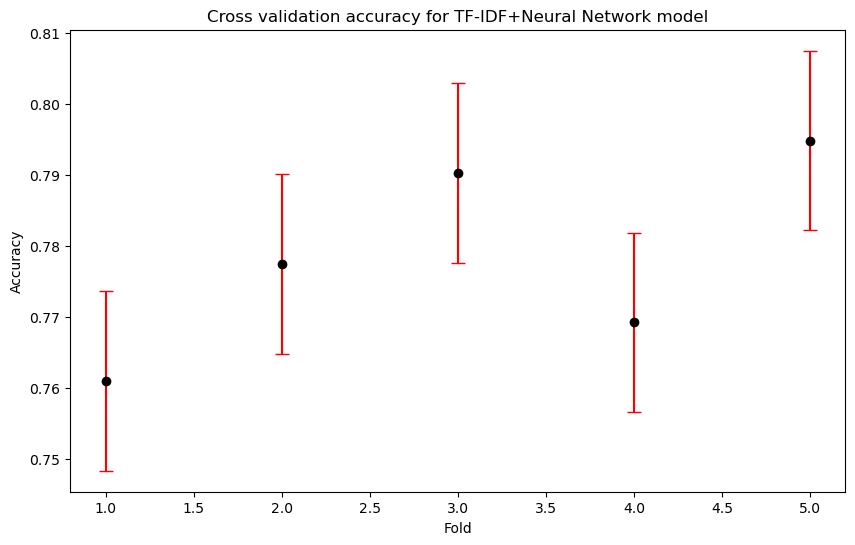

In [39]:
plt.figure(figsize=(10, 6))
plt.title('Cross validation accuracy for TF-IDF+Neural Network model')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.errorbar(range(1, 6), accuracies, yerr=np.std(accuracies), fmt='o', color='black', ecolor='red', capsize=5)

### Using CountVectorizer to vecotrize the data

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['sypnopsis'], df['Score'], test_size=0.25, random_state=42)
bin_X_train, bin_X_test, bin_y_train, bin_y_test = train_test_split(df['sypnopsis'], df['Score_class'], test_size=0.3, random_state=42)
bin_X_val, bin_X_test, bin_y_val, bin_y_test = train_test_split(bin_X_test, bin_y_test, test_size=0.5, random_state=42)


# Initialize the CountVectorizer
vectorizer = CountVectorizer(max_features=1024, ngram_range=(1, 2))
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)


# Initialize the CountVectorizer for binary classification
bin_vectorizer = CountVectorizer(max_features=1024, ngram_range=(1, 2))
bin_vectorizer.fit(bin_X_train)
bin_X_train = bin_vectorizer.transform(bin_X_train)
bin_X_test = bin_vectorizer.transform(bin_X_test)
bin_X_val = bin_vectorizer.transform(bin_X_val)




### Train a linear regression model

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


# Fit the LinearRegression model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f'R^2 score: {r2}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean squared error: {mse}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean absolute error: {mae}')

R^2 score: 0.18753950818940113
Mean squared error: 0.6964459210639206
Mean absolute error: 0.6472748584149342


In [42]:
bin_X_train = bin_X_train.toarray()
bin_X_test = bin_X_test.toarray()
bin_X_val = bin_X_val.toarray()

### Create a sequentail neural network model and train it on the data

In [43]:
from sklearn.metrics import classification_report
from tensorflow.keras import regularizers

# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='tanh', kernel_regularizer=regularizers.l2(0.005), input_shape=(bin_X_train.shape[1],)),
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_focal_crossentropy', optimizer='sgd', metrics=['accuracy'])
# Train the model
history = model.fit(bin_X_train, bin_y_train, epochs=50, batch_size=32, validation_data=(bin_X_val, bin_y_val), verbose=1)

Epoch 1/50


c:\Users\afara\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7311 - loss: 3.5183 - val_accuracy: 0.7666 - val_loss: 3.3798
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7821 - loss: 3.3389 - val_accuracy: 0.7874 - val_loss: 3.2223
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7911 - loss: 3.1826 - val_accuracy: 0.7880 - val_loss: 3.0754
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7970 - loss: 3.0383 - val_accuracy: 0.7734 - val_loss: 2.9385
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8053 - loss: 2.8991 - val_accuracy: 0.7880 - val_loss: 2.8041
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8082 - loss: 2.7671 - val_accuracy: 0.7850 - val_loss: 2.6796
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8071 - loss: 2.6435 - val_accuracy: 0.7831 - val_loss: 2.5587
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8190 - loss: 2.5204 - val_accuracy: 0.7783 - val_

### Plot the model loss and validation loss vs the number of epochs

In [44]:
# Evaluate the model
loss, accuracy = model.evaluate(bin_X_test, bin_y_test)
print(f'Test accuracy: {accuracy}')

y_pred_prob = model.predict(bin_X_test)

y_pred = (y_pred_prob > 0.5).astype("int32")

print(classification_report(bin_y_test, y_pred))

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7601 - loss: 0.4539
Test accuracy: 0.7582417726516724
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      1216
           1       0.55      0.35      0.43       422

    accuracy                           0.76      1638
   macro avg       0.67      0.62      0.64      1638
weighted avg       0.73      0.76      0.74      1638



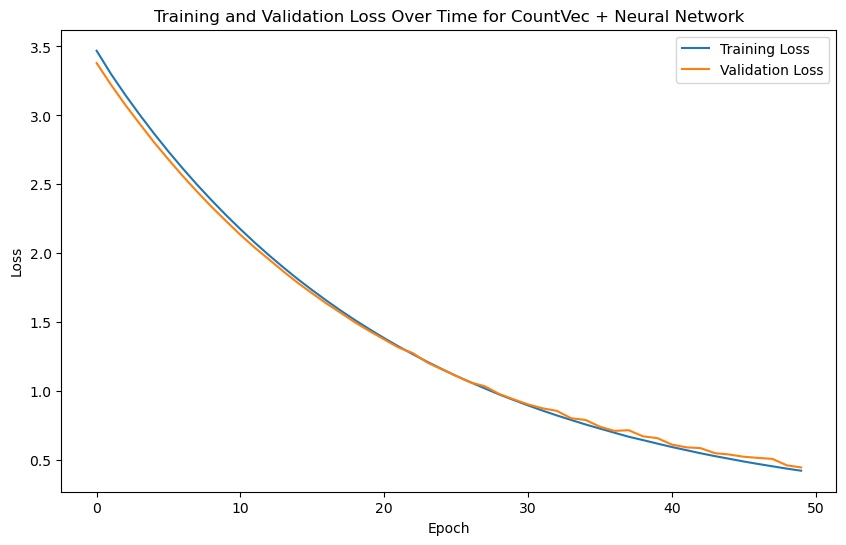

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Time for CountVec + Neural Network')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50


c:\Users\afara\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7279 - loss: 3.5039 - val_accuracy: 0.7516 - val_loss: 3.3605
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7841 - loss: 3.3022 - val_accuracy: 0.7544 - val_loss: 3.1852
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7958 - loss: 3.1293 - val_accuracy: 0.7681 - val_loss: 3.0210
Epoch 4/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8036 - loss: 2.9668 - val_accuracy: 0.7644 - val_loss: 2.8703
Epoch 5/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8108 - loss: 2.8111 - val_accuracy: 0.7736 - val_loss: 2.7199
Epoch 6/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8053 - loss: 2.6674 - val_accuracy: 0.7782 - val_loss: 2.5817
Epoch 7/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8072 - loss: 2.5337 - val_accuracy: 0.7773 - val_loss: 2.4519
Epoch 8/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8201 - loss: 2.4010 - val_accuracy: 0.7764 - val_

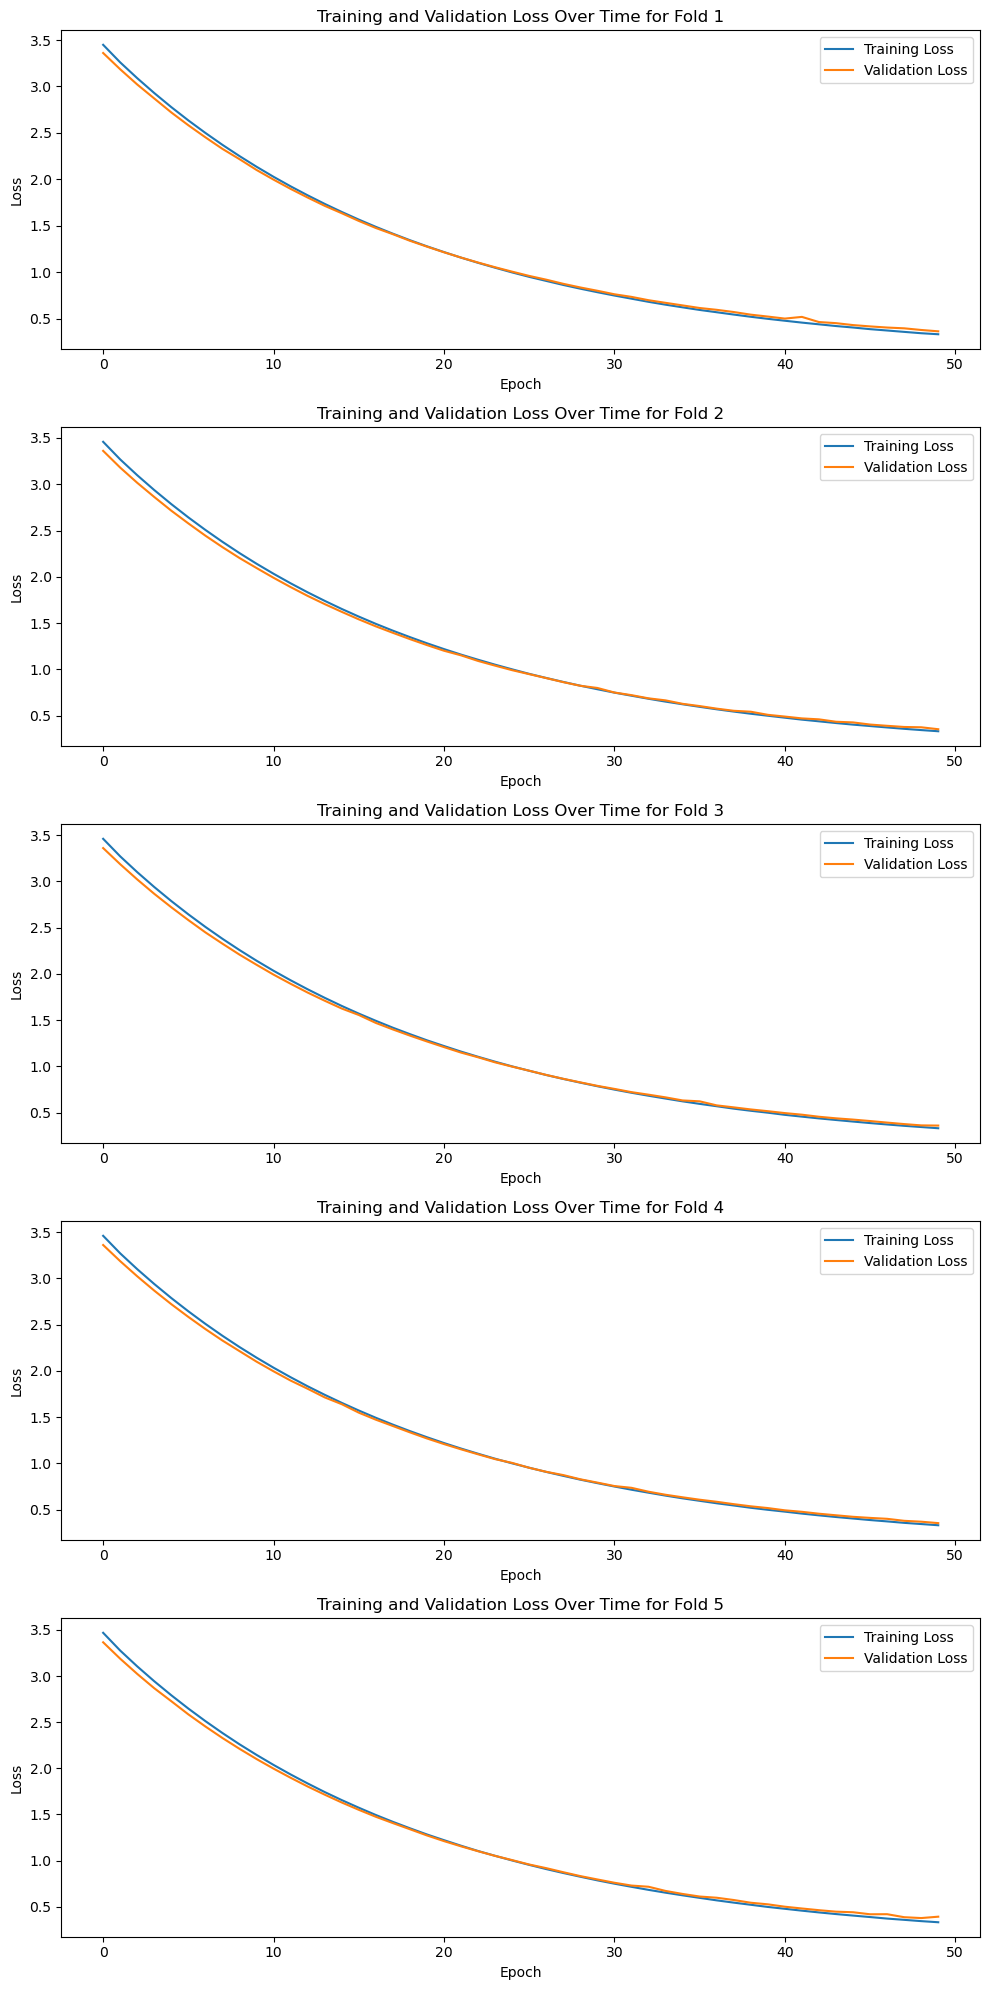

In [46]:
X = df['sypnopsis']
y = df['Score_class']

kFold = StratifiedKFold(n_splits=5, shuffle=True)

i = 1

accuracies = []
fig, axes = plt.subplots(5,1, figsize=(10, 20))
for train_index, test_index in kFold.split(X, y):
    bin_X_train, bin_X_test = X.iloc[train_index], X.iloc[test_index]
    bin_y_train, bin_y_test = y.iloc[train_index], y.iloc[test_index]
    bin_X_val, bin_X_test, bin_y_val, bin_y_test = train_test_split(bin_X_test, bin_y_test, test_size=0.5, random_state=42)
    
    bin_vectorizer = CountVectorizer(max_features=1024, ngram_range=(1, 2))
    bin_vectorizer.fit(bin_X_train)
    bin_X_train = bin_vectorizer.transform(bin_X_train)
    bin_X_test = bin_vectorizer.transform(bin_X_test)
    bin_X_val = bin_vectorizer.transform(bin_X_val)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(512, activation='tanh', kernel_regularizer=regularizers.l2(0.005), input_shape=(bin_X_train.shape[1],)),
        tf.keras.layers.Dense(256, activation='tanh'),
        tf.keras.layers.Dense(128, activation='tanh'),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(1, activation='sigmoid')])
    model.compile(loss='binary_focal_crossentropy', optimizer='sgd', metrics=['accuracy'])
    print('------------------------------------------------------------------------')
    print(f'Training for fold {i} ...')

    history = model.fit(bin_X_train, bin_y_train, epochs=50, batch_size=32, validation_data=(bin_X_val, bin_y_val), verbose=1)
    loss, accuracy = model.evaluate(bin_X_test, bin_y_test)
    accuracies.append(accuracy)
    ax = axes[i-1]
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_title('Training and Validation Loss Over Time for Fold ' + str(i))
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    i+=1
    
plt.tight_layout()
plt.show()
    

In [47]:
mean_accuracy = np.mean(accuracies)
print(f'Mean accuracy: {mean_accuracy}')
print(accuracies)

Mean accuracy: 0.7844322443008422
[0.7884615659713745, 0.773809552192688, 0.7948718070983887, 0.7902930378913879, 0.7747252583503723]


<ErrorbarContainer object of 3 artists>

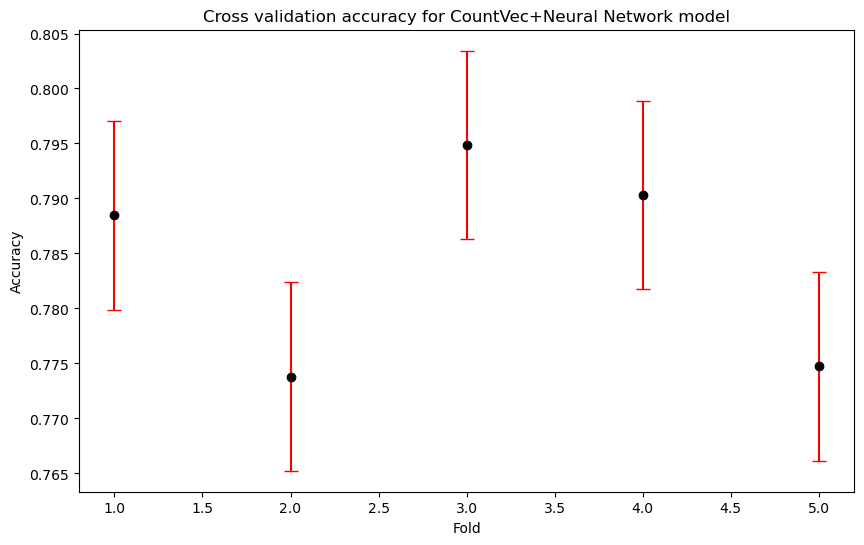

In [48]:
plt.figure(figsize=(10, 6))
plt.title('Cross validation accuracy for CountVec+Neural Network model')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.errorbar(range(1, 6), accuracies, yerr=np.std(accuracies), fmt='o', color='black', ecolor='red', capsize=5)